In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import yaml

from utils import load_experiment_dir

matplotlib.style.use('seaborn-notebook')
matplotlib.pyplot.rcParams['figure.figsize'] = (16, 10)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
%%time
two_headed_dir = "../exps/task1/two_headed_param_search/"

results = load_experiment_dir(two_headed_dir)

CPU times: user 59.6 s, sys: 1.38 s, total: 1min
Wall time: 1min 14s


# Fix hacks during development

In [183]:
results['early_stopping_strategy'] = results['early_stopping_strategy'].fillna('ratio')
results['epochs_run'] = results['train_loss'].apply(len)
results['speed'] = results['running_time'] / results['epochs_run']
results['share_embedding'] = results['share_embedding'].fillna(False)
results.loc[results['share_embedding'] == True, 'lemma_embedding_size'] = results.loc[results['share_embedding'] == True, 'inflected_embedding_size']

# Parameters changed across experiments

Not uniformly distributed

In [175]:
var_params = [
    'lemma_embedding_size',
    'lemma_hidden_size',
    'lemma_num_layers',

    'tag_embedding_size',
    'tag_hidden_size',
    'tag_num_layers',

    'inflected_embedding_size',
    'inflected_hidden_size',
    'inflected_num_layers',

    'dropout',
    'early_stopping_strategy',
    'early_stopping_ratio',
    
    'language',
]
fixed_params = [
    'batch_size', 'early_stopping_window', 'epochs', 'optimizer',
    'share_embedding', 'share_vocab', 'model', 'dataset_class',
    'save_min_epoch',
]

params = var_params + fixed_params

In [184]:
results.groupby('language').dev_acc.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
arabic,200.0,0.799470,0.035740,0.578,0.7820,0.8050,0.82600,0.870
breton,1033.0,0.709197,0.287026,0.000,0.7500,0.8500,0.87000,0.930
latin,610.0,0.623239,0.112959,0.001,0.5950,0.6495,0.69075,0.789
lithuanian,243.0,0.802506,0.083687,0.004,0.7905,0.8250,0.84400,0.884
zulu,234.0,0.943248,0.166479,0.000,0.9670,0.9740,0.98000,0.992


In [176]:
def save_n_best_config(results, n, save_dir, extra_params={}):
    """Saves N best configs by language"""
    best = results.loc[results.groupby('language').dev_acc.nlargest(n).unstack().columns][params]
    for i, row in enumerate(best.iterrows()):
        as_dict = dict(row[1])
        if 'early_stopping_ratio' in as_dict:
            del as_dict['early_stopping_ratio']
        if 'language' in as_dict:
            as_dict['orig_language'] = as_dict['language']
            del as_dict['language']
        as_dict['early_stopping_window'] = int(as_dict['early_stopping_window'])
        as_dict.update(extra_params)
        with open(os.path.join(save_dir, "config_{0:02d}.yaml".format(i)), 'w') as f:
            yaml.dump(as_dict, f, default_flow_style=False)
    
save_n_best_config(results[results.early_stopping_strategy=='dev_loss_increase'], 5,
                   "../config/task1/two_headed/best_configs_new/",
                   extra_params={'experiment_dir': 'exps/task1/two_headed_best'})

## arabic and zulu

In [188]:
arab_zulu = results[
    (results.language=='arabic') |
    (results.language=='zulu')
]
arab_zulu.early_stopping_strategy.value_counts()
save_n_best_config(arab_zulu, 3, "../config/task1/two_headed/best_configs_arab_zulu/",
                   extra_params={'experiment_dir': 'exps/task1/two_headed_arab_zulu_best/'})

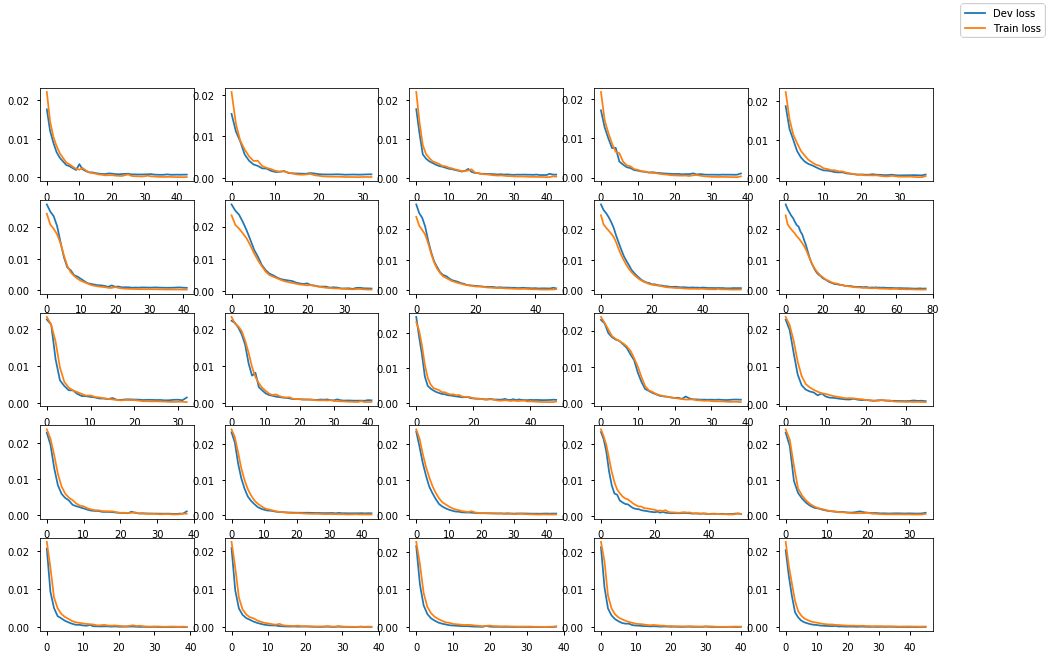

In [177]:
N = 5
M = len(results.groupby('language'))
best = results[results.early_stopping_strategy=='dev_loss_increase'].groupby('language').dev_acc.nlargest(N)
fig, ax = plt.subplots(M, N, figsize=(16, 10))
lang_map = {}
col_cnt = 0
for (lang, idx) in best.index:
    if lang not in lang_map:
        lang_map[lang] = len(lang_map)
        col_cnt = 0
    #fig.plot(results.loc[idx].dev_loss, ax=ax[lang_map[lang]][col_cnt])
    #plt.plot(results.loc[idx].dev_loss, ax=ax[lang_map[lang]][col_cnt])
    dev = ax[lang_map[lang]][col_cnt].plot(results.loc[idx].dev_loss)
    train = ax[lang_map[lang]][col_cnt].plot(results.loc[idx].train_loss)
    fig.legend(labels=['Dev loss', 'Train loss'])
    col_cnt += 1
    
#fig.legend( lines, labels, loc = (0.5, 0), ncol=5 )

In [ ]:
for row in results[results.early_stopping_strategy=='dev_loss_increase'].iterrows():
    plt.plot(row[1].dev_loss)

In [158]:
results.groupby(['early_stopping_strategy', 'language']).dev_acc.agg(['mean', 'max', 'size'])

mean    max  size
early_stopping_strategy language                         
dev_loss_increase       arabic      0.810100  0.870    50
                        breton      0.852921  0.930   623
                        latin       0.622676  0.789   586
                        lithuanian  0.810785  0.884   200
                        zulu        0.888869  0.992    84
ratio                   breton      0.490805  0.930   410
                        latin       0.637000  0.750    24
                        lithuanian  0.762262  0.869    42

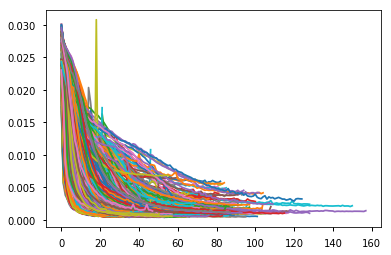

In [35]:
for row in results[results.early_stopping_strategy=='dev_loss_increase'].iterrows():
    plt.plot(row[1].dev_loss)

In [159]:
result_cols = ['dev_acc', 'train_acc']

In [163]:
results['convergence'] = (results.dev_loss.apply(lambda x: sum(x[-10:-5])) > 
                                results.dev_loss.apply(lambda x: sum(x[-5:])))

In [164]:
results[results.convergence == True].groupby(['language', 'lemma_hidden_size'])[result_cols].agg(['max', 'mean', 'size'])

dev_acc                train_acc               
                                 max      mean size       max      mean size
language   lemma_hidden_size                                                
breton     128                 0.880  0.520811  111  0.979324  0.593327  111
           256                 0.890  0.482091  110  0.992436  0.557232  110
           512                 0.890  0.392155  116  0.980837  0.458609  116
           1024                0.880  0.551034   58  0.976803  0.638261   58
latin      128                 0.732  0.642375   16  0.951700  0.863144   16
           256                 0.763  0.671357   14  0.932800  0.869879   14
           512                 0.757  0.636318   22  0.967400  0.860527   22
           1024                0.717  0.495958   24  0.966100  0.779771   24
lithuanian 128                 0.838  0.748250    4  0.958000  0.857175    4
           256                 0.847  0.787800    5  0.958400  0.925140    5
           512                 0.864  0.745833    6  0.970800  0.891067    6
           1024                0.855  0.720692   13  0.963400  0.878146   13

In [165]:
results.groupby(['language', 'lemma_hidden_size'])[result_cols].agg(['max', 'mean', 'std'])

dev_acc                     train_acc            \
                                 max      mean       std       max      mean   
language   lemma_hidden_size                                                   
arabic     512                 0.857  0.811846  0.034179  0.992900  0.957308   
           1024                0.870  0.808208  0.040538  0.992400  0.963113   
breton     128                 0.920  0.738290  0.266771  0.989914  0.828465   
           256                 0.930  0.713966  0.284095  0.996470  0.802601   
           512                 0.930  0.664897  0.317850  0.984367  0.750703   
           1024                0.930  0.726294  0.260383  0.992940  0.820541   
latin      128                 0.766  0.631894  0.061588  0.964000  0.805954   
           256                 0.775  0.648706  0.080129  0.979900  0.840132   
           512                 0.789  0.611084  0.144353  0.983700  0.853815   
           1024                0.757  0.530422  0.174391  0.972200  0.804729   
lithuanian 128                 0.872  0.815868  0.042668  0.968600  0.933697   
           256                 0.869  0.817027  0.042756  0.970500  0.939601   
           512                 0.884  0.792699  0.118373  0.971900  0.921634   
           1024                0.855  0.726375  0.102875  0.963400  0.879525   
zulu       512                 0.991  0.943681  0.164703  0.999300  0.963204   
           1024                0.992  0.636733  0.466826  0.998700  0.655753   

                                        
                                   std  
language   lemma_hidden_size            
arabic     512                0.038478  
           1024               0.031445  
breton     128                0.291596  
           256                0.306572  
           512                0.344957  
           1024               0.279800  
latin      128                0.091846  
           256                0.103351  
           512                0.126338  
           1024               0.158562  
lithuanian 128                0.042264  
           256                0.021757  
           512                0.111667  
           1024               0.075511  
zulu       512                0.167738  
           1024               0.480252